## Import libraries

In [32]:
import pandas as pd

import preprocess as pp

from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import length
from pyspark.sql.functions import col

from pyspark.ml.feature import Tokenizer,StopWordsRemover,CountVectorizer,IDF,StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vector
from pyspark.ml.classification import NaiveBayes
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

import seaborn as sns
from matplotlib import pyplot as plt

## Data Preparation and General Basic Exploration

In [33]:
output,labels = pp.preprocess('train.iob')

Number of Samples 4478
Number of Intent 21


There are 4,478 rows of data in the training data set with 21 different labels that describe intent.

Note: Prior to preprocessing, the "BOS" airport code was found at the beginning of every row. We can infer/assume from this that all of the text was collected in the data set is from the Boston Logan Airport. 

In [3]:
df = pd.DataFrame.from_dict(output, orient='columns')
df.head()

,intent,tags,text
0,atis_flight,EOS O O O O O O B-fromloc.city_name O B-toloc...,i want to fly from baltimore to dallas round ...
1,atis_airfare,EOS O B-round_trip I-round_trip O O B-fromloc...,round trip fares from baltimore to philadelph...
2,atis_flight,EOS O O O O O O O B-toloc.city_name O B-arriv...,show me the flights arriving on baltimore on ...
3,atis_flight,EOS O O O O O O O O B-fromloc.city_name I-fro...,what are the flights which depart from san fr...
4,atis_airline,EOS O O O O O B-fromloc.city_name O B-toloc.c...,which airlines fly from boston to washington ...


There are 3 columns in the preprocessed dataset - one with labels that we want to predict called "intent". 
The second column is a common tagging notation characteristic of iob files for chunking in NLP called "tags". 
These tags describe the parts of the text stored in the "text" column that provide meaning for further analysis.

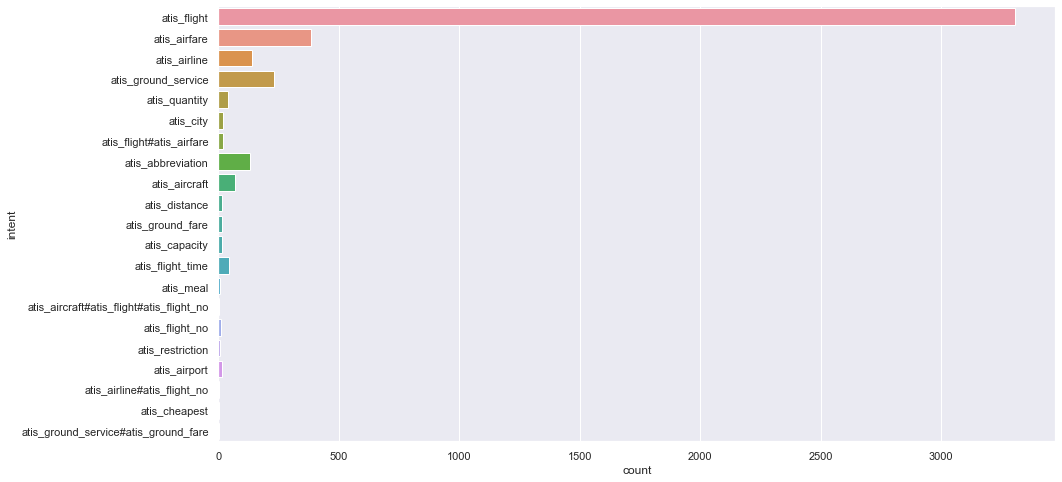

In [30]:
sns.set(style="darkgrid")
plt.figure(figsize=(15,8))
ax = sns.countplot(y="intent", data=df)
ax

A quick visualization of the frequency distribution of the labels present in the training data shows an overwhelming
majority of the labels present are "atis_flight".

Now, let's do another quick at the same information for the test dataset.

In [36]:
output_test,labels_test = pp.preprocess('test.iob')

Number of Samples 500
Number of Intent 16


There are 500 rows of data in the training data set with 16 different labels that describe intent.
Compared with our training data, this has a significantly less amount of rows (to be expected).
The test data also does not contain as many labels present as the training set. Remember this!

In [48]:
pct_output, pct_output_test = ((len(output) / (len(output) + len(output_test)))*100), ((len(output_test) / (len(output) + len(output_test)))*100)
round(pct_output), round(pct_output_test)

(90, 10)

We see that the split between our training and testing data is 90% training and 10% testing. 
This may be important information for tuning later down the road if these splits may need to be adjusted.

In [5]:
df_test = pd.DataFrame.from_dict(output_test, orient='columns')
df_test.head()

,intent,tags,text
0,atis_flight,EOS O O O O O O B-fromloc.city_name O B-depar...,i want to fly from boston at 838 am and arriv...
1,atis_flight,EOS O O O O B-round_trip I-round_trip O O B-f...,show me all round trip flights between housto...
2,atis_flight,EOS O O O O O O O O O O B-fromloc.city_name O...,i would like some information on a flight fro...
3,atis_flight,EOS O O O O B-class_type O O B-fromloc.city_n...,what are the coach flights between dallas and...
4,atis_flight,EOS O O O O B-fromloc.city_name O O B-toloc.c...,i'm flying from boston to the bay area


Above, we verify that our test data is in the same format and contains the same data types as our training set.

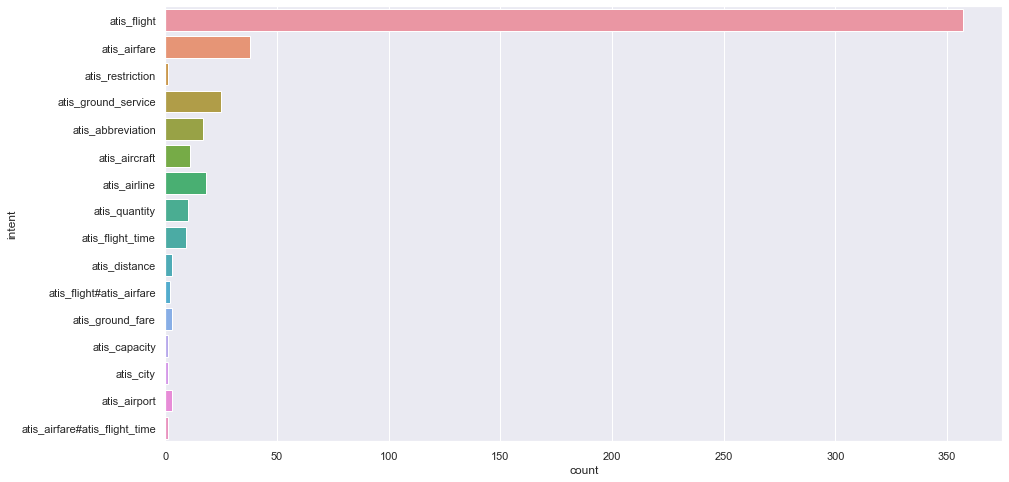

In [49]:
plt.figure(figsize=(15,8))
ax_test = sns.countplot(y="intent", data=df_test)
ax_test

Above, although we see that there are less labels to visualize, we can still verify that the majority of the labels
in the test data are also "atis_flight".

## Model Preparation, Ad-Hoc Analysis, Final Preprocessing

Using pyspark to show thoughts about future scalability.
First, let's create a Spark session and convert the Pandas dataframe into Spark dataframes. Let's also enable Arrow to optimmize this conversion process.

In [6]:
spark = SparkSession.builder.appName('nlp').getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
spark_df = spark.createDataFrame(df)
spark_df_test = spark.createDataFrame(df_test)

Let's take a peek at both of our training and test Spark dataframes to make sure everything still looks good after the conversion.

In [7]:
spark_df.show()

+-------------------+--------------------+--------------------+
|             intent|                tags|                text|
+-------------------+--------------------+--------------------+
|        atis_flight| EOS O O O O O O ...| i want to fly fr...|
|       atis_airfare| EOS O B-round_tr...| round trip fares...|
|        atis_flight| EOS O O O O O O ...| show me the flig...|
|        atis_flight| EOS O O O O O O ...| what are the fli...|
|       atis_airline| EOS O O O O O B-...| which airlines f...|
|        atis_flight| EOS O O O O O O ...| i'm looking for ...|
|        atis_flight| EOS O O O O O B-...| okay and then fr...|
|        atis_flight| EOS O O O O O O ...| show me all the ...|
|        atis_flight| EOS O O O O O O ...| okay i'd like a ...|
|        atis_flight| EOS O O B-depart...| on tuesday what ...|
|        atis_flight| EOS O B-airline_...| american flights...|
|atis_ground_service| EOS O O O O O O ...| what types of gr...|
|        atis_flight| EOS O O O B-depa..

In [8]:
spark_df_test.show()

+-------------------+--------------------+--------------------+
|             intent|                tags|                text|
+-------------------+--------------------+--------------------+
|        atis_flight| EOS O O O O O O ...| i want to fly fr...|
|        atis_flight| EOS O O O O B-ro...| show me all roun...|
|        atis_flight| EOS O O O O O O ...| i would like som...|
|        atis_flight| EOS O O O O B-cl...| what are the coa...|
|        atis_flight| EOS O O O O B-fr...| i'm flying from ...|
|        atis_flight| EOS O O O O O O ...| okay can you tel...|
|        atis_flight| EOS O O B-fromlo...| from montreal to...|
|        atis_flight| EOS O O O O B-fl...| what is the earl...|
|        atis_flight| EOS O O O B-from...| flights from pit...|
|        atis_flight| EOS O O O O B-fl...| what is the late...|
|        atis_flight| EOS O O O B-from...| flights from ont...|
|       atis_airfare| EOS O O O O O O ...| i would like to ...|
|        atis_flight| EOS O O O O O O ..

Looks good!

Now, to focus on model preparation, we don't need the tags column to make this kind of analysis. So, let's go ahead and drop it from both the training and test Spark dataframes. We could have done this before the conversion, but choosing to drop it at this point in case we want to come back and use it for another model later on or want to do further analysis on it while it is still in a Pandas dataframe.

In [9]:
spark_df = spark_df.drop("tags")
spark_df.show()

+-------------------+--------------------+
|             intent|                text|
+-------------------+--------------------+
|        atis_flight| i want to fly fr...|
|       atis_airfare| round trip fares...|
|        atis_flight| show me the flig...|
|        atis_flight| what are the fli...|
|       atis_airline| which airlines f...|
|        atis_flight| i'm looking for ...|
|        atis_flight| okay and then fr...|
|        atis_flight| show me all the ...|
|        atis_flight| okay i'd like a ...|
|        atis_flight| on tuesday what ...|
|        atis_flight| american flights...|
|atis_ground_service| what types of gr...|
|        atis_flight| in the next two ...|
|        atis_flight| does continental...|
|        atis_flight| chicago to milwa...|
|      atis_quantity| how many flights...|
|        atis_flight| show me the flig...|
|       atis_airfare| i'd like to find...|
|      atis_quantity| how many booking...|
|        atis_flight| what are the fli...|
+----------

In [10]:
spark_df_test = spark_df_test.drop("tags")
spark_df_test.show()

+-------------------+--------------------+
|             intent|                text|
+-------------------+--------------------+
|        atis_flight| i want to fly fr...|
|        atis_flight| show me all roun...|
|        atis_flight| i would like som...|
|        atis_flight| what are the coa...|
|        atis_flight| i'm flying from ...|
|        atis_flight| okay can you tel...|
|        atis_flight| from montreal to...|
|        atis_flight| what is the earl...|
|        atis_flight| flights from pit...|
|        atis_flight| what is the late...|
|        atis_flight| flights from ont...|
|       atis_airfare| i would like to ...|
|        atis_flight| okay that sounds...|
|       atis_airfare| show me the pric...|
|        atis_flight| flights from cin...|
|        atis_flight| i'm interested i...|
|        atis_flight| i am interested ...|
|        atis_flight| i'm looking for ...|
|   atis_restriction| what's restricti...|
|atis_ground_service| what types of gr...|
+----------

Still looking good! 

We are continuing to prep our data for modeling. We will need to use the length of the strings in the text 
columns for the model, so let's add a custom column that contains the length of the string in the text column.

In [11]:
spark_df = spark_df.withColumn('length',length(spark_df['text']))
spark_df.orderBy(col("length").desc()).show(25)

+--------------------+--------------------+------+
|              intent|                text|length|
+--------------------+--------------------+------+
|         atis_flight| i want to travel...|   260|
|        atis_airfare| round trip fares...|   217|
|       atis_aircraft| all right would ...|   216|
|        atis_airfare| round trip fares...|   211|
|        atis_airfare| round trip fares...|   211|
|       atis_aircraft| i'm going to lea...|   197|
|         atis_flight| i would like to ...|   191|
|      atis_flight_no| i would like the...|   176|
|         atis_flight| what flights can...|   176|
|         atis_flight| tell me about fl...|   170|
|         atis_flight| please list all ...|   167|
|atis_aircraft#ati...| i want to fly fr...|   165|
|         atis_flight| i would like to ...|   161|
|         atis_flight| i am interested ...|   158|
|         atis_flight| i would like to ...|   156|
|         atis_flight| i would like to ...|   156|
|         atis_flight| i would 

We'll also continue to manipulate both the training and test data in the same way.

In [12]:
spark_df_test = spark_df_test.withColumn('length',length(spark_df_test['text']))
spark_df_test.orderBy(col("length").desc()).show(25)

+----------------+--------------------+------+
|          intent|                text|length|
+----------------+--------------------+------+
|     atis_flight| find me the earl...|   180|
|     atis_flight| find me the earl...|   179|
|     atis_flight| i'd like to arra...|   166|
|     atis_flight| i am interested ...|   162|
|     atis_flight| great now what i...|   156|
|     atis_flight| i would like the...|   144|
|     atis_flight| thank you for th...|   139|
|   atis_aircraft| well i'll try la...|   137|
|     atis_flight| show me flights ...|   130|
|     atis_flight| can you list all...|   125|
|   atis_aircraft| sure i'd like to...|   125|
|     atis_flight| i would like to ...|   123|
|atis_flight_time| please give me t...|   122|
|     atis_flight| could i have a l...|   121|
|     atis_flight| i would like to ...|   120|
|     atis_flight| okay that sounds...|   119|
|atis_flight_time| i would like the...|   114|
|     atis_flight| show me the chea...|   114|
|     atis_fl

Hey, while we're here, maybe let's see if we can draw a bit more insight by counting the exact number of intent labels.
We visualized this earlier in the Notebook, but now we can see some raw numbers.

In [13]:
spark_df.groupBy("intent").count().orderBy(col("count").desc()).show(25, False)

+----------------------------------------+-----+
|intent                                  |count|
+----------------------------------------+-----+
|atis_flight                             |3309 |
|atis_airfare                            |385  |
|atis_ground_service                     |230  |
|atis_airline                            |139  |
|atis_abbreviation                       |130  |
|atis_aircraft                           |70   |
|atis_flight_time                        |45   |
|atis_quantity                           |41   |
|atis_flight#atis_airfare                |19   |
|atis_city                               |18   |
|atis_airport                            |17   |
|atis_distance                           |17   |
|atis_capacity                           |15   |
|atis_ground_fare                        |15   |
|atis_flight_no                          |12   |
|atis_meal                               |6    |
|atis_restriction                        |5    |
|atis_airline#atis_f

The atis_flight intent label is seen the greatest amount of time at 3,309 occurances.
atis_aircraft#atis_flight#atis_flight_no, atis_ground_service#atis_ground_fare, and atis_cheapest all come in as a tie for last place with only 1 occurance in the dataset.

Let's do the same check on the test data.

In [14]:
spark_df_test.groupBy("intent").count().orderBy(col("count").desc()).show(25, False)

+-----------------------------+-----+
|intent                       |count|
+-----------------------------+-----+
|atis_flight                  |357  |
|atis_airfare                 |38   |
|atis_ground_service          |25   |
|atis_airline                 |18   |
|atis_abbreviation            |17   |
|atis_aircraft                |11   |
|atis_quantity                |10   |
|atis_flight_time             |9    |
|atis_airport                 |3    |
|atis_distance                |3    |
|atis_ground_fare             |3    |
|atis_flight#atis_airfare     |2    |
|atis_capacity                |1    |
|atis_restriction             |1    |
|atis_airfare#atis_flight_time|1    |
|atis_city                    |1    |
+-----------------------------+-----+



Interesting. While atis_flight is still the clear winner in the test data, atis_capacity, atis_restriction, atis_airfare#atis_flight_time,
and atis_city come in the tie for the least amount of occurances. From a very high level, this makes us feel more confident that 
there is an acceptable expectation of randomness in the datasets.

While we're here, we might as well take a look at the average length of text that correspond to each intent label.

In [15]:
spark_df.groupby('intent').mean().orderBy(col("avg(length)").desc()).show(25, False)

+----------------------------------------+------------------+
|intent                                  |avg(length)       |
+----------------------------------------+------------------+
|atis_aircraft#atis_flight#atis_flight_no|165.0             |
|atis_ground_service#atis_ground_fare    |106.0             |
|atis_airline#atis_flight_no             |103.0             |
|atis_flight_no                          |92.83333333333333 |
|atis_flight#atis_airfare                |77.21052631578948 |
|atis_aircraft                           |77.0              |
|atis_flight_time                        |74.08888888888889 |
|atis_airfare                            |67.83116883116882 |
|atis_flight                             |66.80568147476579 |
|atis_quantity                           |63.8780487804878  |
|atis_distance                           |59.05882352941177 |
|atis_ground_service                     |56.65217391304348 |
|atis_airline                            |54.29496402877698 |
|atis_gr

Looks like text that contains the highest amount of words/characters is text that has the atis_aircraft#atis_flight#atis_flight_no intent.

Looks like text that contains the least amount of words/characters is text that has the atis_abbreviation intent label.

In [16]:
spark_df_test.groupby('intent').mean().orderBy(col("avg(length)").desc()).show(25, False)

+-----------------------------+------------------+
|intent                       |avg(length)       |
+-----------------------------+------------------+
|atis_flight_time             |82.88888888888889 |
|atis_aircraft                |80.72727272727273 |
|atis_flight#atis_airfare     |75.0              |
|atis_airfare#atis_flight_time|70.0              |
|atis_flight                  |68.63585434173669 |
|atis_airfare                 |66.63157894736842 |
|atis_distance                |63.333333333333336|
|atis_quantity                |59.4              |
|atis_ground_fare             |57.333333333333336|
|atis_ground_service          |54.28             |
|atis_airline                 |51.94444444444444 |
|atis_capacity                |42.0              |
|atis_airport                 |32.666666666666664|
|atis_abbreviation            |26.058823529411764|
|atis_restriction             |24.0              |
|atis_city                    |17.0              |
+-----------------------------+

For the test dataset, looks like text that contains the highest amount of words/characters is text that has the atis_flight_time intent label. 
Looks like text that contains the least amount of words/characters is text that has the atis_city intent label.

Further statistical analysis can be done to understand these differences in average between the training and test data better, 
but I'm sure there is further insight to discover here.

Finally, we arrive at some true manipulation needed for NLP ML Pipeline. 

1. First, we create a new token_text column computed after tokenizing our text column. 
Tokenization is the process of taking text (such as a sentence) and breaking it into individual terms (usually words)
2. Stop words are words which should be excluded from the input, typically because the words appear frequently 
and don’t carry as much meaning. StopWordsRemover takes as input a sequence of strings (e.g. the output of a Tokenizer) 
and drops all the stop words from the input sequences. 
3. CountVectorizer will help convert a collection of text documents to vectors of token counts.
4. IDF is a feature vectorization method used to reflect the importance of a term to a document in the corpus.
5. StringIndexer encodes a string column of labels to a column of label indices. In this case, it creates a numeric 
values to represent intent labels. Also, remember when we said to remember that our training and test data had a 
different number of intent labels? The handleInvalid='keep' parameter is important here to align the dimensionality 
of our training and test datasets.
6. And finally, the VectorAssembler is a transformer that combines a given list of columns into a single vector column. 
This is the important and unique part of these Spark dataframes.

In [54]:
tokenizer = Tokenizer(inputCol="text", outputCol="token_text")
stopremove = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens')
count_vec = CountVectorizer(inputCol='stop_tokens',outputCol='c_vec')
idf = IDF(inputCol="c_vec", outputCol="tf_idf")
to_num = StringIndexer(inputCol='intent',outputCol='label', handleInvalid='keep')
clean_up = VectorAssembler(inputCols=['tf_idf','length'],outputCol='features')

Create a pipeline to execute these different manipulation stages and fit it on the training data.

In [18]:
data_prep_pipe = Pipeline(stages=[to_num,tokenizer,stopremove,count_vec,idf,clean_up])
cleaner = data_prep_pipe.fit(spark_df)

Transform the dataframe according to the stages of the pipeline.
Select the label and features columns to create a final version of the prepared training data to be used in the model.

In [19]:
clean_data = cleaner.transform(spark_df)
clean_data = clean_data.select(['label','features'])
clean_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(771,[10,11,20,25...|
|  1.0|(771,[6,9,11,12,2...|
|  0.0|(771,[1,4,11,35,1...|
|  0.0|(771,[1,5,7,16,19...|
|  3.0|(771,[3,15,16,20,...|
|  0.0|(771,[2,57,59,67,...|
|  0.0|(771,[8,9,13,139,...|
|  0.0|(771,[1,4,12,140,...|
|  0.0|(771,[2,5,13,34,3...|
|  0.0|(771,[1,44,54,57,...|
|  0.0|(771,[1,21,38,69,...|
|  2.0|(771,[5,7,26,28,5...|
|  0.0|(771,[5,20,41,84,...|
|  0.0|(771,[5,6,7,15,20...|
|  0.0|(771,[58,69,770],...|
|  7.0|(771,[1,32,111,11...|
|  0.0|(771,[1,4,10,11,2...|
|  1.0|(771,[3,12,13,22,...|
|  7.0|(771,[117,251,363...|
|  0.0|(771,[1,5,27,124,...|
+-----+--------------------+
only showing top 20 rows



In [ ]:
Apply the transformation to the test dataframe as well (only fit on training data).
Select the label and features columns to create a final version of the prepared training data to be used in the model.

In [20]:
clean_data_test = cleaner.transform(spark_df_test)
clean_data_test = clean_data_test.select(['label','features'])
clean_data_test.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  0.0|(771,[3,6,20,21,4...|
|  0.0|(771,[1,4,25,29,6...|
|  0.0|(771,[2,5,6,7,13,...|
|  0.0|(771,[1,10,11,17,...|
|  0.0|(771,[3,183,405,7...|
|  0.0|(771,[2,6,8,89,99...|
|  0.0|(771,[67,68,119,7...|
|  0.0|(771,[2,12,48,80,...|
|  0.0|(771,[1,9,11,19,1...|
|  0.0|(771,[2,3,5,7,98,...|
|  0.0|(771,[1,227,260,7...|
|  1.0|(771,[2,6,11,13,2...|
|  0.0|(771,[8,10,21,22,...|
|  1.0|(771,[1,4,8,16,47...|
|  0.0|(771,[1,38,137,14...|
|  0.0|(771,[2,8,9,214,7...|
|  0.0|(771,[2,10,21,60,...|
|  0.0|(771,[2,6,10,24,8...|
| 16.0|(771,[202,770],[5...|
|  2.0|(771,[12,26,28,34...|
+-----+--------------------+
only showing top 20 rows



Create the training model.
We'll use the Naive Bayes Classifier because it works well for multiclass text classification.

In [21]:
nb = NaiveBayes()

Fit the Naive Bayes model to the final cleaned data.
Save the model to be used for distribution.

In [55]:
nb_model = nb.fit(clean_data)
nb_model.save("AtisIntentModel")

Apply the trained model to the final cleaned test data and view the results.

In [56]:
test_results = nb_model.transform(clean_data_test)
test_results.show()

+-----+--------------------+--------------------+--------------------+----------+
|label|            features|       rawPrediction|         probability|prediction|
+-----+--------------------+--------------------+--------------------+----------+
|  0.0|(771,[3,6,20,21,4...|[-262.60829273404...|[0.90773958661435...|       0.0|
|  0.0|(771,[1,4,25,29,6...|[-152.94190779362...|[0.99961058009422...|       0.0|
|  0.0|(771,[2,5,6,7,13,...|[-136.82394603755...|[0.99999971679131...|       0.0|
|  0.0|(771,[1,10,11,17,...|[-266.83317010945...|[0.99999436188869...|       0.0|
|  0.0|(771,[3,183,405,7...|[-136.31286220297...|[1.14885453396266...|       5.0|
|  0.0|(771,[2,6,8,89,99...|[-151.44490095486...|[9.73804853776641...|       1.0|
|  0.0|(771,[67,68,119,7...|[-93.175953670689...|[0.99999979510715...|       0.0|
|  0.0|(771,[2,12,48,80,...|[-159.70310486567...|[0.99999999661637...|       0.0|
|  0.0|(771,[1,9,11,19,1...|[-133.98816300143...|[0.99998803321003...|       0.0|
|  0.0|(771,[2,3

Evaluate the accuracy of the model when applied to the test data.

In [57]:
acc_eval = MulticlassClassificationEvaluator()
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting was: {}".format(acc))

Accuracy of model at predicting was: 0.8887484743919528


Around 88% accuracy? Not bad. We can continue trying new models, try optimized parameters, try using neural networks, 
or even probe deeper into the data itself to improve. 